In [1]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.1 MB 3.9 MB/s eta 0:00:02
   --------------- ------------------------ 3.1/8.1 MB 6.1 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 8.1 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 8.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 8.1 MB/s  0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------------------------------------- -- 2.1/2.3 MB 11.1 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 8.1 MB/s  0:00:00
   -------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import math
import os
import random
from collections import Counter
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Input,
    LeakyReLU,
    MaxPooling2D,
    UpSampling2D,
    concatenate,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ✅ Set reproducibility seeds
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# ✅ Check the Dataset folder structure
dataset_path = "Dataset"
if os.path.exists(dataset_path):
    print("Dataset folders found:")
    print(sorted(os.listdir(dataset_path)))
else:
    print(f"Warning: {dataset_path} folder not found!")


Dataset folders found:
['Antique', 'Dress', 'Food', 'House', 'Ku', 'Kuthang', 'Mask', 'Mask dance', 'Painting', 'Royal', 'Sports']


In [4]:
# Base dataset path
DatasetPath = "Dataset"

Image shape: (224, 224, 3)
Loaded image: 1.jpg


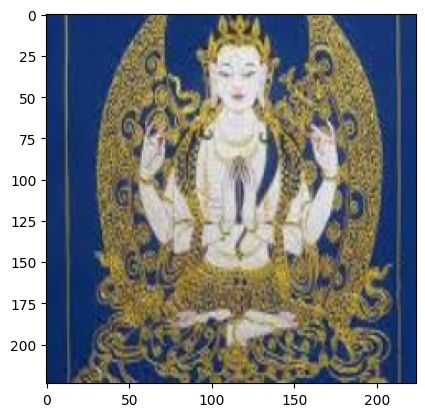

In [5]:
# Test loading an image from the Painting folder
test_image_path = os.path.join(DatasetPath, "Painting")
if os.path.exists(test_image_path):
    # Get first image from Painting folder
    images = [f for f in os.listdir(test_image_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if images:
        img = cv2.imread(os.path.join(test_image_path, images[0]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        plt.imshow(img)
        print(f"Image shape: {img.shape}")
        print(f"Loaded image: {images[0]}")
    else:
        print("No images found in Painting folder")
else:
    print(f"Path not found: {test_image_path}")


In [ ]:
HEIGHT = 224
WIDTH = 224
SUPPORTED_EXTENSIONS = (".jpg", ".jpeg", ".png", ".webp", ".avif")


def collect_image_paths(dataset_path: str):
    """Return image paths and category labels for everything inside `dataset_path`."""
    dataset_root = Path(dataset_path)
    if not dataset_root.exists():
        raise FileNotFoundError(f"Dataset path '{dataset_path}' not found")

    image_paths, categories = [], []
    for category_dir in sorted(dataset_root.iterdir()):
        if not category_dir.is_dir():
            continue
        for image_path in sorted(category_dir.iterdir()):
            if image_path.suffix.lower() in SUPPORTED_EXTENSIONS:
                image_paths.append(str(image_path))
                categories.append(category_dir.name)

    stats = Counter(categories)
    print(f"Discovered {len(image_paths)} images across {len(stats)} categories.")
    for category, count in stats.most_common():
        print(f"  • {category:<12} : {count:>4}")

    return image_paths, categories


def random_affine_transform(image: np.ndarray):
    """Apply small random affine transforms suitable for colorization."""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    # Rotation (±12°)
    if random.random() < 0.5:
        angle = random.uniform(-12.0, 12.0)
    else:
        angle = 0.0

    # Scale (±10%)
    scale = random.uniform(0.9, 1.1)

    # Translation (±5%)
    max_shift_x = w * 0.05
    max_shift_y = h * 0.05
    shift_x = random.uniform(-max_shift_x, max_shift_x)
    shift_y = random.uniform(-max_shift_y, max_shift_y)

    matrix = cv2.getRotationMatrix2D(center, angle, scale)
    matrix[0, 2] += shift_x
    matrix[1, 2] += shift_y

    augmented = cv2.warpAffine(
        image,
        matrix,
        (w, h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REFLECT_101,
    )
    return augmented


def color_jitter(image: np.ndarray):
    """Randomly adjust brightness and contrast while keeping values valid."""
    image = image.astype(np.float32)
    if random.random() < 0.5:
        brightness = random.uniform(0.85, 1.15)
    else:
        brightness = 1.0

    if random.random() < 0.5:
        contrast = random.uniform(0.9, 1.1)
    else:
        contrast = 1.0

    jittered = ((image - 127.5) * contrast + 127.5) * brightness
    return np.clip(jittered, 0, 255).astype(np.uint8)


def preprocess_lab(image: np.ndarray):
    """Convert RGB image to normalized L and ab tensors."""
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab).astype(np.float32)
    L = image_lab[:, :, 0:1] / 255.0  # Scale to [0, 1]
    ab = (image_lab[:, :, 1:] - 128) / 128.0  # Scale to [-1, 1]
    return L, ab


class ColorizationDataGenerator(tf.keras.utils.Sequence):
    """Keras Sequence for efficient loading + augmentation on small datasets."""

    def __init__(
        self,
        image_paths,
        batch_size=8,
        augment=False,
        shuffle=True,
        target_size=(HEIGHT, WIDTH),
    ):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.target_size = target_size
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.image_paths) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        batch_paths = [self.image_paths[i] for i in batch_indices]

        X_batch = np.zeros((len(batch_paths), *self.target_size, 1), dtype=np.float32)
        y_batch = np.zeros((len(batch_paths), *self.target_size, 2), dtype=np.float32)

        for idx, image_path in enumerate(batch_paths):
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.target_size[::-1])

            if self.augment:
                if random.random() < 0.5:
                    image = cv2.flip(image, 1)  # horizontal flip
                image = random_affine_transform(image)
                image = color_jitter(image)

            L, ab = preprocess_lab(image)
            X_batch[idx] = L
            y_batch[idx] = ab

        return X_batch, y_batch

In [ ]:
image_paths, category_labels = collect_image_paths(DatasetPath)

df = pd.DataFrame({"path": image_paths, "category": category_labels})
display(df.sample(min(5, len(df))))

test_size = 0.15
val_size = 0.15

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths,
    category_labels,
    test_size=(test_size + val_size),
    stratify=category_labels,
    random_state=42,
)

val_relative = val_size / (test_size + val_size)
val_paths, test_paths, _, _ = train_test_split(
    temp_paths,
    temp_labels,
    test_size=1 - val_relative,
    stratify=temp_labels,
    random_state=42,
)

print(
    f"Train: {len(train_paths)} | Validation: {len(val_paths)} | Test: {len(test_paths)}"
)

BATCH_SIZE = 12
train_generator = ColorizationDataGenerator(
    train_paths,
    batch_size=BATCH_SIZE,
    augment=True,
    shuffle=True,
)
val_generator = ColorizationDataGenerator(
    val_paths,
    batch_size=BATCH_SIZE,
    augment=False,
    shuffle=False,
)
test_generator = ColorizationDataGenerator(
    test_paths,
    batch_size=BATCH_SIZE,
    augment=False,
    shuffle=False,
)

Found 11 category folders: ['Antique', 'Dress', 'Food', 'House', 'Ku', 'Kuthang', 'Mask', 'Mask dance', 'Painting', 'Royal', 'Sports']

Processing folder: Antique
  Found 142 images

Processing folder: Dress
  Found 121 images

Processing folder: Food
  Found 7 images

Processing folder: House
  Found 67 images

Processing folder: Ku
  Found 60 images

Processing folder: Kuthang
  Found 14 images

Processing folder: Mask
  Found 153 images

Processing folder: Mask dance
  Found 517 images

Processing folder: Painting
  Found 603 images

Processing folder: Royal
  Found 56 images

Processing folder: Sports
  Found 9 images

Total images loaded: 1740
X_ shape: (1740, 224, 224)
y_ shape: (1740, 224, 224, 2)


In [ ]:
sample_L, sample_ab = train_generator[0]
print(f"Batch L shape: {sample_L.shape} | Batch ab shape: {sample_ab.shape}")

plt.figure(figsize=(12, 6))
for idx in range(min(4, sample_L.shape[0])):
    plt.subplot(2, 4, idx + 1)
    plt.imshow(sample_L[idx].squeeze(), cmap="gray")
    plt.axis("off")
    if idx == 0:
        plt.title("L channel (input)")

    plt.subplot(2, 4, idx + 5)
    lab = np.zeros((HEIGHT, WIDTH, 3), dtype=np.float32)
    lab[:, :, 0:1] = sample_L[idx] * 255.0
    lab[:, :, 1:] = (sample_ab[idx] * 128.0) + 128.0
    lab_uint8 = np.clip(lab, 0, 255).astype(np.uint8)
    rgb = cv2.cvtColor(lab_uint8, cv2.COLOR_Lab2RGB)
    plt.imshow(rgb)
    plt.axis("off")
    if idx == 0:
        plt.title("Reconstructed RGB")
plt.tight_layout()
plt.show()

In [ ]:
def conv_block(inputs, filters, kernel_size=3):
    x = Conv2D(filters, kernel_size, padding="same")(inputs)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    return x


def build_colorization_model(input_shape=(HEIGHT, WIDTH, 1)):
    inputs = Input(shape=input_shape, name="l_channel")

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2), padding="same")(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2), padding="same")(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2), padding="same")(c3)

    bottleneck = conv_block(p3, 512)

    # Decoder
    u2 = UpSampling2D((2, 2))(bottleneck)
    concat2 = concatenate([u2, c3], axis=-1)
    c4 = conv_block(concat2, 256)

    u1 = UpSampling2D((2, 2))(c4)
    concat1 = concatenate([u1, c2], axis=-1)
    c5 = conv_block(concat1, 128)

    u0 = UpSampling2D((2, 2))(c5)
    concat0 = concatenate([u0, c1, inputs], axis=-1)
    c6 = conv_block(concat0, 64)

    outputs = Conv2D(2, (1, 1), activation="tanh", name="ab_channels")(c6)

    return Model(inputs=inputs, outputs=outputs, name="BhutanColorizer")

NameError: name 'K' is not defined

In [ ]:
K.clear_session()
Model_Colourization = build_colorization_model()
Model_Colourization.summary()

In [ ]:
LEARNING_RATE = 1e-4
Model_Colourization.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="mean_squared_error",
    metrics=["mae"],
)

checkpoint_dir = Path("checkpoints")
checkpoint_dir.mkdir(exist_ok=True)

callbacks = [
    ModelCheckpoint(
        filepath=str(checkpoint_dir / "bhutan_colorizer_best.keras"),
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        min_lr=5e-6,
        verbose=1,
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=12,
        restore_best_weights=True,
        verbose=1,
    ),
]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 224, 224,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      4,640 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 224, 224,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 112, 112,  │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ leaky_re_lu_3[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 56, 56,    │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ leaky_re_lu_4[0]

 Total params: 820,386 (3.13 MB)

 Trainable params: 819,042 (3.12 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [ ]:
EPOCHS = 100
history = Model_Colourization.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks,
)

pd.DataFrame(history.history)[["loss", "val_loss"]].plot(figsize=(8, 4), title="Training vs Validation Loss")
plt.show()

pd.DataFrame(history.history)[["mae", "val_mae"]].plot(figsize=(8, 4), title="Training vs Validation MAE")
plt.show()

Epoch 1/53
 11/217 ━━━━━━━━━━━━━━━━━━━━ 2:54 847ms/step - loss: 0.1852 - mae: 0.3141

KeyboardInterrupt: 

In [ ]:
best_model_path = checkpoint_dir / "bhutan_colorizer_best.keras"
latest_model_path = Path("bhutan_colorizer_latest.keras")
Model_Colourization.save(latest_model_path)
print(f"Latest model snapshot saved to {latest_model_path}")

if best_model_path.exists():
    best_model = tf.keras.models.load_model(best_model_path)
    print(f"Best model restored from {best_model_path}")
else:
    print("Best checkpoint not found; using the latest model for evaluation.")
    best_model = Model_Colourization

print("Evaluating on the held-out test set...")
test_loss, test_mae = best_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f} | Test MAE: {test_mae:.4f}")

# Ensure downstream cells use the best-performing weights
Model_Colourization = best_model

In [ ]:
# Example: How to load the saved model later
# Uncomment the following lines when you want to load a previously saved model:

# from keras.models import load_model
# loaded_model = load_model("colorization_model.h5")
# print("Model loaded successfully!")
# loaded_model.summary()


In [ ]:
# For testing, we'll use images from the Painting folder
TestImagePath = os.path.join(DatasetPath, "Painting")

In [ ]:
def prepare_inference_tensors(image_path, target_size=(HEIGHT, WIDTH)):
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise FileNotFoundError(f"Could not read image at {image_path}")

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb = cv2.resize(image_rgb, target_size[::-1])

    # Normalize color ground-truth for visualization/comparison
    lab_full = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab).astype(np.float32)
    L_gt = lab_full[:, :, 0:1] / 255.0
    ab_gt = (lab_full[:, :, 1:] - 128) / 128.0

    # Simulate grayscale input for the model
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    lab_gray = cv2.cvtColor(gray_rgb, cv2.COLOR_RGB2Lab).astype(np.float32)
    L_input = lab_gray[:, :, 0:1] / 255.0

    return L_input[np.newaxis, ...], (L_gt, ab_gt), image_rgb


def predict_and_reconstruct(model, l_input_batch):
    pred_ab = model.predict(l_input_batch, verbose=0)
    l_channel = l_input_batch[0, :, :, 0:1] * 255.0
    ab_channels = pred_ab[0] * 128.0 + 128.0

    lab_image = np.concatenate([l_channel, ab_channels], axis=-1)
    lab_uint8 = np.clip(lab_image, 0, 255).astype(np.uint8)
    rgb_pred = cv2.cvtColor(lab_uint8, cv2.COLOR_Lab2RGB)
    return rgb_pred


# Legacy compatibility helper for downstream cells

def ExtractTestInput(ImagePath):
    l_input_batch, _, _ = prepare_inference_tensors(ImagePath)
    return l_input_batch

In [ ]:
# Helper to visualize predictions against ground truth

def visualize_prediction(image_path, model):
    L_input_batch, (L_gt, ab_gt), rgb_gt = prepare_inference_tensors(image_path)
    rgb_pred = predict_and_reconstruct(model, L_input_batch)

    gray = (L_input_batch[0, :, :, 0] * 255.0).astype(np.uint8)
    gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(gray_rgb, cmap="gray")
    plt.title("Model Input (Grayscale)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(rgb_pred)
    plt.title("Predicted Colorization")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(rgb_gt)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.show()


sample_category = "Painting"
sample_category_path = os.path.join(DatasetPath, sample_category)
sample_images = [
    os.path.join(sample_category_path, f)
    for f in os.listdir(sample_category_path)
    if f.lower().endswith(SUPPORTED_EXTENSIONS)
]

if sample_images:
    print(f"Visualizing predictions on {sample_category} samples")
    for image_path in sample_images[:3]:
        print(f"→ {Path(image_path).name}")
        visualize_prediction(image_path, best_model)
else:
    print(f"No images found inside {sample_category_path}")

In [ ]:
def visualize_grid(image_paths, model, columns=3):
    rows = math.ceil(len(image_paths) / columns)
    plt.figure(figsize=(6 * columns, 4 * rows))
    for idx, image_path in enumerate(image_paths):
        L_input_batch, (_, _), rgb_gt = prepare_inference_tensors(image_path)
        rgb_pred = predict_and_reconstruct(model, L_input_batch)
        gray = (L_input_batch[0, :, :, 0] * 255.0).astype(np.uint8)

        base_idx = idx * 3
        plt.subplot(rows, columns * 3, base_idx + 1)
        plt.imshow(gray, cmap="gray")
        plt.axis("off")
        if idx == 0:
            plt.title("Input L")

        plt.subplot(rows, columns * 3, base_idx + 2)
        plt.imshow(rgb_pred)
        plt.axis("off")
        if idx == 0:
            plt.title("Prediction")

        plt.subplot(rows, columns * 3, base_idx + 3)
        plt.imshow(rgb_gt)
        plt.axis("off")
        if idx == 0:
            plt.title("Ground Truth")
    plt.tight_layout()
    plt.show()


if len(test_paths) > 0:
    sample_paths = random.sample(test_paths, min(4, len(test_paths)))
    print("Colorization results on random held-out test images:")
    visualize_grid(sample_paths, best_model, columns=2)
else:
    print("Test split is empty; unable to visualize.")

In [ ]:
def colorize_external_image(image_path: str, destination_path: str | None = None, model=best_model):
    """Colorize a grayscale (or color) image and optionally save the output."""
    L_input_batch, _, _ = prepare_inference_tensors(image_path)
    rgb_pred = predict_and_reconstruct(model, L_input_batch)

    if destination_path:
        cv2.imwrite(destination_path, cv2.cvtColor(rgb_pred, cv2.COLOR_RGB2BGR))
        print(f"Colorized image saved to {destination_path}")
    return rgb_pred


# Example usage (provide your own grayscale photo path)
# new_image_path = "path/to/grayscale_photo.jpg"
# output_path = "outputs/colorized_photo.jpg"
# os.makedirs(os.path.dirname(output_path), exist_ok=True)
# result_rgb = colorize_external_image(new_image_path, output_path)
# plt.imshow(result_rgb)
# plt.axis("off")

In [ ]:
# (Deprecated cell replaced during refactor – intentionally left blank)

In [ ]:
# (Deprecated cell replaced during refactor – intentionally left blank)

In [ ]:
# Test with an image from a different category (e.g., Antique)
test_category = "Antique"
test_category_path = os.path.join(DatasetPath, test_category)
if os.path.exists(test_category_path):
    test_images = [f for f in os.listdir(test_category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if test_images:
        test_img_name = test_images[0]
        TestImagePath = os.path.join(test_category_path, test_img_name)
        print(f"Testing with image from {test_category}: {test_img_name}")
        image_for_test = ExtractTestInput(TestImagePath)
        Prediction_3 = Model_Colourization.predict(image_for_test)
        Prediction_3 = Prediction_3*128
        Prediction_3=Prediction_3.reshape(224,224,2)
    else:
        print(f"No images found in {test_category} folder")
else:
    print(f"Category folder {test_category} not found")

In [ ]:
plt.figure(figsize=(30,20))
test_category = "Antique"
test_category_path = os.path.join(DatasetPath, test_category)
if os.path.exists(test_category_path):
    test_images = [f for f in os.listdir(test_category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if test_images:
        test_img_name = test_images[0]
        TestImagePath = os.path.join(test_category_path, test_img_name)
        plt.subplot(5,5,1)
        img = cv2.imread(TestImagePath)
        img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, (224, 224))
        plt.imshow(img)

        plt.subplot(5,5,1+1)
        img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        img_[:,:,1:] = Prediction_3
        img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
        plt.title("Predicted Image")
        plt.imshow(img_)

        plt.subplot(5,5,1+2)
        plt.title("Ground truth")
        plt.imshow(img_1)

In [ ]:
# Test with another image from Painting folder
test_category_path = os.path.join(DatasetPath, "Painting")
if os.path.exists(test_category_path):
    test_images = [f for f in os.listdir(test_category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(test_images) > 3:
        test_img_name = test_images[3]
        TestImagePath = os.path.join(test_category_path, test_img_name)
        print(f"Testing with image: {test_img_name}")
        image_for_test = ExtractTestInput(TestImagePath)
        Prediction_4 = Model_Colourization.predict(image_for_test)
        Prediction_4 = Prediction_4*128
        Prediction_4=Prediction_4.reshape(224,224,2)
    else:
        print("Not enough test images found!")
else:
    print("Painting folder not found")

In [ ]:
plt.figure(figsize=(30,20))
test_category_path = os.path.join(DatasetPath, "Painting")
if os.path.exists(test_category_path):
    test_images = [f for f in os.listdir(test_category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(test_images) > 3:
        test_img_name = test_images[3]
        TestImagePath = os.path.join(test_category_path, test_img_name)
        plt.subplot(5,5,1)
        img = cv2.imread(TestImagePath)
        img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, (224, 224))
        plt.imshow(img)

        plt.subplot(5,5,1+1)
        img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        img_[:,:,1:] = Prediction_4
        img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
        plt.title("Predicted Image")
        plt.imshow(img_)

        plt.subplot(5,5,1+2)
        plt.title("Ground truth")
        plt.imshow(img_1)

In [ ]:
# Test with another image from Painting folder
test_category_path = os.path.join(DatasetPath, "Painting")
if os.path.exists(test_category_path):
    test_images = [f for f in os.listdir(test_category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(test_images) > 4:
        test_img_name = test_images[4]
        TestImagePath = os.path.join(test_category_path, test_img_name)
        print(f"Testing with image: {test_img_name}")
        image_for_test = ExtractTestInput(TestImagePath)
        Prediction_5 = Model_Colourization.predict(image_for_test)
        Prediction_5 = Prediction_5*128
        Prediction_5=Prediction_5.reshape(224,224,2)
    else:
        print("Not enough test images found!")
else:
    print("Painting folder not found")

In [ ]:
plt.figure(figsize=(30,20))
test_category_path = os.path.join(DatasetPath, "Painting")
if os.path.exists(test_category_path):
    test_images = [f for f in os.listdir(test_category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(test_images) > 4:
        test_img_name = test_images[4]
        TestImagePath = os.path.join(test_category_path, test_img_name)
        plt.subplot(5,5,1)
        img = cv2.imread(TestImagePath)
        img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, (224, 224))
        plt.imshow(img)

        plt.subplot(5,5,1+1)
        img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        img_[:,:,1:] = Prediction_5
        img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
        plt.title("Predicted Image")
        plt.imshow(img_)

        plt.subplot(5,5,1+2)
        plt.title("Ground truth")
        plt.imshow(img_1)